In [2]:
import pandas as pd
import numpy as np

# import three files, takes very long
df_all = pd.read_csv('criteo-uplift-v2.1.csv')
df_treated = df_all[df_all.treatment == 1] #pd.read_csv('criteo_treated.csv', encoding='latin_1')
df_untreated = df_all[df_all.treatment == 0] #pd.read_csv('criteo_not_treated.csv', encoding='latin_1')

df_all.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

In [3]:
#These are the number of rows in each file. Treated and Untreated data were extracted from the total data.
count_all = df_all['conversion'].count()
count_treated = df_treated['conversion'].count()
count_untreated = df_untreated['conversion'].count()
print(count_all,count_treated,count_untreated)

13979592 11882655 2096937


#### By the number of untreated data, select these numbers of data randomly from all/treated/untreated
* 60% train = 1258163
* 20% validation = 419387
* 20% test = 419387
#### To do this, I shuffle each dataset and choose corresponding number of rows from them, so that we are in fact randomly selecting our training, validating and testing set

In [143]:
#Shuffle data to make sure random selection
from sklearn.utils import shuffle
df_untreated = shuffle(df_untreated)
df_treated = shuffle(df_treated)
df_all = shuffle(df_all)

In [20]:
#Set the number of train, validation and test data we want to use
train = 1258163   
val = 419387
test = 419387
learn = train

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

features = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
def build_classifier(df, dependent_variable,learn):
    #print(dependent_variable)
    X, y = df[features][:learn], df[dependent_variable][:learn] #learning set is learn, validation set is train always
    X_val, y_val = df[features][train:train+val], df[dependent_variable][train:train+val]
    # If we use the default solver, the model does not converge
    clf = DecisionTreeClassifier(min_samples_leaf = 10000).fit(X, y)
    #print(f"Accuracy: {clf.score(X_val, y_val)}")
    #fpr, tpr, thresholds = metrics.roc_curve(y_val, clf.predict_proba(X_val)[:,1])
    #print(f"AUC: {metrics.auc(fpr, tpr)}")
    return clf
def build_classifier_regression(df, dependent_variable,learn):
    #print(dependent_variable)
    X, y = df[features][:learn], df[dependent_variable][:learn] #learning set is learn, validation set is train always
    X_val, y_val = df[features][train:train+val], df[dependent_variable][train:train+val]
    # If we use the default solver, the model does not converge
    clf = DecisionTreeClassifier(min_samples_leaf = 10000).fit(X, y)
    #print(f"Accuracy: {clf.score(X_val, y_val)}")
    #fpr, tpr, thresholds = metrics.roc_curve(y_val, clf.predict_proba(X_val)[:,1])
    #print(f"AUC: {metrics.auc(fpr, tpr)}")
    return clf

## Model 1: All data, predict conversion

In [6]:
#Model 1: run logistic regression for all data (including treated and untreated) to predict conversion
clf_all = build_classifier(df_all, 'conversion',learn)

conversion
Accuracy: 0.9971863696299599
AUC: 0.9533271812088813


## Model 2: All data, predict visit

In [7]:
#Model 2: run logistic regression for all data (including treated and untreated) to predict visit
clf_all_visit = build_classifier(df_all, 'visit',learn)

visit
Accuracy: 0.9575785610903533
AUC: 0.930821675698435


## Model 3: Treated data, predict conversion

In [8]:
clf_treated = build_classifier(df_treated, 'conversion',learn)

conversion
Accuracy: 0.9969693862709145
AUC: 0.94817294604042


## Model 4: Treated data, predict visit

In [9]:
clf_treated_visit = build_classifier(df_treated, 'visit',learn)

visit


C:\Users\ferlo\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ferlo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Accuracy: 0.9569013822555301
AUC: 0.9296869991995043


## Model 5: Untreated data, predict conversion

In [10]:
clf_untreated = build_classifier(df_untreated, 'conversion',learn)

conversion
Accuracy: 0.9980853006888626
AUC: 0.9576730124568793


## Model 6: Untreated data, predict visit

In [11]:
clf_untreated_visit = build_classifier(df_untreated, 'visit',learn)

visit
Accuracy: 0.9638639252051208
AUC: 0.9320007823572166


## Model 1 Prediction
### After building the models, we do evaluation and prediction using validation data
* some data in val_set might be the same with training data in untreated/treated data set
* val_set is completely separated from training data of model 1

In [10]:
val_set = df_all[train:train+val]

## Now we see the features of the validation set

In [11]:
#porportion of people treated
targeted = val_set.treatment.mean()
targeted

0.8499571994363202

In [12]:
#conversion rate on treated
treat_all = val_set[val_set.treatment == 1].conversion.mean()
treat_all

0.0030578380243561007

In [13]:
#conversion rate on not treated
treat_none = val_set[val_set.treatment == 0].conversion.mean()
treat_none

0.0023360772971426757

In [14]:
#conversion rate if treat randomly (according to the percentage treated)
treat_random = treat_all*targeted+treat_none*(1-targeted)
treat_random

0.00294954302350812

## Now, we target top 10% and see the result

In [16]:
def do_targeting(scores, val_set):
    results = val_set[['treatment', 'conversion']].copy()
    # Do the targeting
    target_size = 41939 #10%
    bottom_score = np.sort(scores)[-target_size]
    results['target_decision'] = (scores >= bottom_score).astype(int)
    # Estimate rewards
    matches = results.target_decision == results.treatment.values
    treatment_rate = val_set.treatment.mean()
    weights = results.treatment * treatment_rate + (1 - results.treatment) * (1 - treatment_rate)
    results['reward'] = val_set.conversion.values * matches / weights
    return results

#all_scores = clf_all.predict_proba(val_set[features])[:, 1]
#m1 = do_targeting(all_scores, val_set)
#m1.reward.value_counts()

In [17]:
#calculte effects
def effect(m):
    treat_with_model = m.reward.mean()
    for_target_treated = m[m.target_decision * m.treatment == 1].conversion.mean()
    for_target_untreated = m[m.target_decision * (1-m.treatment) == 1].conversion.mean()
    avg_effect = treat_all-treat_none
    effect_for_targeted = for_target_treated - for_target_untreated
    return treat_with_model,for_target_treated,for_target_untreated,avg_effect,effect_for_targeted

#effect1 = effect(m1)
#effect1

## Model 3 Prediction 

In [19]:
tr_scores = clf_treated.predict_proba(val_set[features])[:, 1]
m3 = do_targeting(tr_scores, val_set)
m3.reward.value_counts()

0.000000    418427
1.176731       939
6.658310        21
Name: reward, dtype: int64

In [20]:
effect3 = effect(m3)
effect3

(0.002968082265278479,
 0.025942093048955686,
 0.01706425213303152,
 0.0010961309120188466,
 0.008877840915924168)

## Model 5 Prediction

In [21]:
un_scores = clf_untreated.predict_proba(val_set[features])[:, 1]
m5 = do_targeting(un_scores, val_set)
m5.reward.value_counts()

0.000000    418426
1.176731       940
6.658310        21
Name: reward, dtype: int64

In [22]:
effect5 = effect(m5)
effect5

(0.0029708881014176482,
 0.026025083750934413,
 0.01683848797250859,
 0.0010961309120188466,
 0.009186595778425823)

## Uplift Prediction
* Create an uplift model by using prediction of treated - untreated

In [23]:
up_scores = tr_scores - un_scores
up = do_targeting(up_scores, val_set)
up.reward.value_counts()

0.000000    418441
1.176731       925
6.658310        21
Name: reward, dtype: int64

In [24]:
effect_up = effect(up)
effect_up

(0.002928800559330108,
 0.025498249579623454,
 0.017308371600141294,
 0.0010961309120188466,
 0.00818987797948216)

### Use Spearmanr correlation to see how closely these models are ranking things

In [25]:
from scipy import stats
stats.spearmanr(all_scores, tr_scores)

SpearmanrResult(correlation=0.9966824583563189, pvalue=0.0)

In [26]:
stats.spearmanr(all_scores, un_scores)

SpearmanrResult(correlation=0.9728851038043155, pvalue=0.0)

In [27]:
stats.spearmanr(tr_scores, un_scores)

SpearmanrResult(correlation=0.9813267666099121, pvalue=0.0)

In [28]:
stats.spearmanr(all_scores, up_scores)

SpearmanrResult(correlation=0.9759418497786646, pvalue=0.0)

In [29]:
stats.spearmanr(tr_scores, up_scores)

SpearmanrResult(correlation=0.9723228431266762, pvalue=0.0)

In [30]:
stats.spearmanr(un_scores, up_scores)

SpearmanrResult(correlation=0.9154893002982973, pvalue=0.0)

## Summarize effect for models

In [31]:
result = pd.DataFrame(np.array([np.array(effect1),np.array(effect3),np.array(effect5),np.array(effect_up)]),index = ['model_all','model_treated','model_untreated','uplift'],columns = ['treat_with_model','for_target_treated','for_target_untreated','avg_effect','effect_for_targeted'])
result

,treat_with_model,for_target_treated,for_target_untreated,avg_effect,effect_for_targeted
model_all,0.002981,0.025920,0.016867,0.001096,0.009054
model_treated,0.002968,0.025942,0.017064,0.001096,0.008878
model_untreated,0.002971,0.026025,0.016838,0.001096,0.009187
uplift,0.002929,0.025498,0.017308,0.001096,0.008190


## Learning curve 12.20

In [87]:
def auc(model,dependent_variable):
    fpr, tpr, thresholds = metrics.roc_curve(val_set[dependent_variable], model.predict_proba(val_set[features])[:,1])
    return metrics.auc(fpr, tpr)
def auc_up(model_tr,model_un,dependent_variable):
    fpr, tpr, thresholds = metrics.roc_curve(val_set[dependent_variable], model_tr.predict_proba(val_set[features])[:,1]-model_un.predict_proba(val_set[features])[:,1])
    return metrics.auc(fpr, tpr)

In [88]:
def reward(model):
    all_scores = model.predict_proba(val_set[features])[:, 1]
    m_temp = do_targeting(all_scores, val_set)
    return effect(m_temp)[0],effect(m_temp)[-1]
def reward_up(model_tr,model_un):
    all_scores = model_tr.predict_proba(val_set[features])[:, 1]-model_un.predict_proba(val_set[features])[:, 1]
    m_temp = do_targeting(all_scores, val_set)
    return effect(m_temp)[0],effect(m_temp)[-1]
#reward, effect_for_targeted
# number of positives as a f of score percentile for uplift, large dataset before jump +tiny dataset (not powerful) model, same distribution?



### Model 1: All data, conversion

In [71]:
auc_score = []
reward_score = []
effect_score = []
for l in range(10000,500000,10000):
    model = build_classifier(df_all, 'conversion',l)
    auc_score.append(auc(model,'conversion'))
    reward_score.append(reward(model)[0])
    effect_score.append(reward(model)[1])

In [49]:
import matplotlib.pyplot as plt
def draw_learning(reward_score,effect_score,a,b,step):
    x = [i for i in range(a,b,step)]
    plt.plot(x, reward_score,label = 'reward')
    #plt.plot(x, auc_score,label = 'auc_score')
    plt.plot(x, effect_score, label = 'effect on targeted')
    plt.xlabel('# of train data')
    plt.ylabel('evaluation score')
    plt.legend()
def draw_learning_auc(auc_score,a,b,step):
    x = [i for i in range(a,b,step)]
    #plt.plot(x, reward_score,label = 'reward_score')
    plt.plot(x, auc_score,label = 'auc_score')
    #plt.plot(x, effect_score, label = 'effect_score')
    plt.xlabel('# of train data')
    plt.ylabel('AUC score')
    plt.legend()

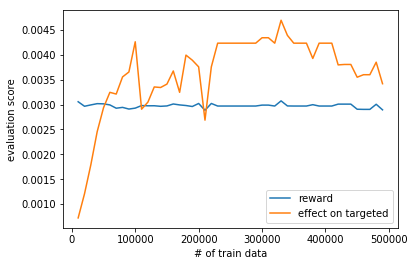

In [50]:
draw_learning(reward_score,effect_score,10000,500000,10000)

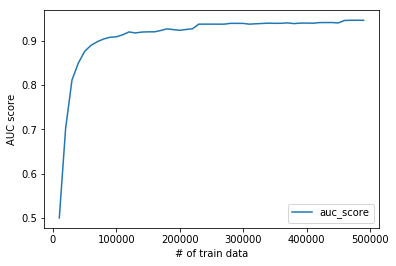

In [51]:
draw_learning_auc(auc_score,10000,500000,10000)

### AUC stops increasing at 100,000
### reward is constant at 0.003
### effect on targeted is around 0.004

In [59]:
reward_score1 = []
effect_score1 = []
for l in range(1000,train,10000):
    model = build_classifier(df_all, 'conversion',l)
    auc_score.append(auc(model,'conversion'))
    reward_score1.append(reward(model)[0])
    effect_score1.append(reward(model)[1])

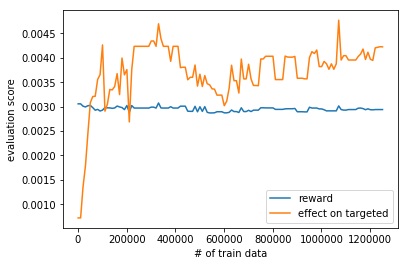

In [60]:
draw_learning(reward_score1,effect_score1,1000,train,10000)

### Model 1: 
* AUC around 0.91 to 0.95 when # of train data >= 100,000
* reward constant around 0.3
* effect on targeted between (0.0030 to 0.0045)

## Model 3: Treated data, conversion

In [66]:
auc_score3 = []
reward_score3 = []
effect_score3 = []
for l in range(10000,500000,10000):
    model = build_classifier(df_treated, 'conversion',l)
    auc_score3.append(auc(model,'conversion'))
    reward_score3.append(reward(model)[0])
    effect_score3.append(reward(model)[1])

In [85]:
#draw_learning(reward_score3,effect_score3,10000,500000,10000)

In [86]:
#draw_learning_auc(auc_score3,10000,500000,10000)

## Model 5: Treated data, conversion

In [70]:
auc_score5 = []
reward_score5 = []
effect_score5 = []
for l in range(10000,500000,10000):
    model = build_classifier(df_untreated, 'conversion',l)
    auc_score5.append(auc(model,'conversion'))
    reward_score5.append(reward(model)[0])
    effect_score5.append(reward(model)[1])

## Uplift (T-learner)

In [138]:
# start with all untreated, increase treated data
auc_score_up = []
reward_score_up = []
effect_score_up = []
model_un = build_classifier(df_untreated, 'conversion',500000)########## constant untreated for now
for l in range(1000,500000,10000):
    model_tr = build_classifier(df_treated, 'conversion',l)
   
    auc_score_up.append(auc_up(model_tr,model_un,'conversion'))
    reward_score_up.append(reward_up(model_tr,model_un)[0])
    effect_score_up.append(reward_up(model_tr,model_un)[1])

In [134]:
def compare(auc_score,auc_score3,auc_score5,auc_score_up,title):

    x = [i for i in range(10000,500000,10000)]
    plt.plot(x, auc_score,label = 'All')
    plt.plot(x, auc_score3,label = 'Treated')
    plt.plot(x, auc_score5,label = 'Untreated')
    plt.plot(x, auc_score_up,label = 'Uplift')
    
    plt.xscale('log')

    plt.xlabel('# of train data')
    plt.ylabel(title)
    plt.legend()

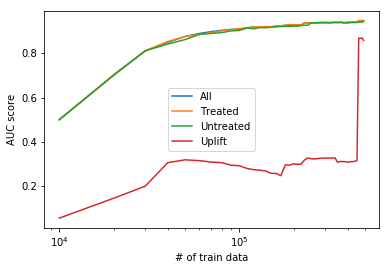

In [139]:
compare(auc_score,auc_score3,auc_score5,auc_score_up[1:],'AUC score')

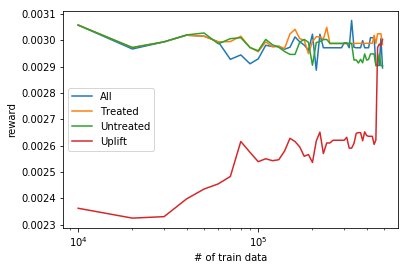

In [140]:
compare(reward_score,reward_score3,reward_score5,reward_score_up[1:],'reward') ##### why is reward going down

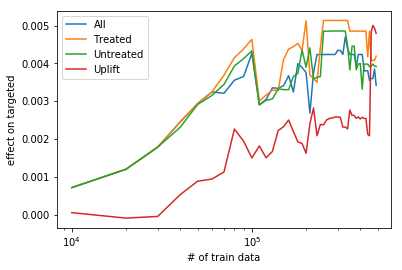

In [141]:
compare(effect_score,effect_score3,effect_score5,effect_score_up[1:],'effect on targeted')

### 200,000

## X-learner

In [129]:
def x_learner(train):
    model_tr = build_classifier(df_treated, 'conversion',train)
    model_un = build_classifier(df_untreated, 'conversion',train)
    d1 = df_treated['conversion']-model_un.predict_proba(df_treated[features])[:, 1]
    d2 = model_tr.predict_proba(df_untreated[features])[:, 1]-df_untreated['conversion']
    df_d1 = df_treated[features]
    df_d2 = df_untreated[features]
    df_d1['d1'] = d1
    df_d2['d2'] = d2
    #print(df_d1.columns)
    model3 = build_classifier(df_d1, 'd1',train) # what models to use for the second stage?
    model4 = build_classifier(df_d2, 'd2',train)
    #0.85,0.15 (which one?)

In [130]:
x_learner(10000)

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'd1'],
      dtype='object')


ValueError: Unknown label type: 'continuous'

In [142]:
auc_score_up

[0.05570547831127816,
 0.05570547831127816,
 0.1451689105619887,
 0.19974780065907968,
 0.3058540684895,
 0.3189314367448489,
 0.315059190252789,
 0.30860901818467246,
 0.30592769030851624,
 0.29445314373635034,
 0.29238571542221575,
 0.2801918747271033,
 0.27450805029003783,
 0.2719783043666085,
 0.2684903476847966,
 0.25803487974081474,
 0.2572688279039473,
 0.24725530353654812,
 0.29642300636895136,
 0.29447052986114786,
 0.30107974350197697,
 0.2984916081933442,
 0.29976318872316576,
 0.31810860885772124,
 0.327377813560926,
 0.3240443532745334,
 0.32302341578290106,
 0.3238852537029614,
 0.32569561463856417,
 0.3263116939910572,
 0.3267346603407955,
 0.3269133673934858,
 0.32666312841401834,
 0.326588389150308,
 0.32770196435370763,
 0.30854879313556427,
 0.310723181013184,
 0.31128782504373353,
 0.31070107764780985,
 0.30993244389504493,
 0.30839722084931404,
 0.30914461928630277,
 0.31130978824519717,
 0.31076422487279154,
 0.31309116521738795,
 0.31517406859389785,
 0.868193710